# Important imports


In [1]:
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob as glb


Current_fit_Left = []
Current_fit_Right = []

# Camera Calibration and undistortion function

In [2]:

def Camera_Calibration(img, nx, ny, objp, img_points, obj_points):
    # Read the undistorted image 
    dist_image = mpimg.imread(img)
    # Covert the undistorted image into grayscale
    gray = cv2.cvtColor(dist_image, cv2.COLOR_RGB2GRAY)
    # find the corners in the chessboard if found
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret == True:
        img_points.append(corners)
        obj_points.append(objp)
        # draw chessboad corners over the original image
        cv2.drawChessboardCorners(dist_image, (nx,ny), corners, ret)
        # calibrate the camera that takes these chessboard images
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)
        # undistort the input image
        undist_image = cv2.undistort(dist_image, mtx, dist, None, mtx)
    
    if ret == False:
        # return the same imput of obj_points and img_points 
        return None,None,obj_points, img_points,None,None
    
    return dist_image, undist_image, obj_points, img_points, mtx, dist 

# Prespective transform

In [3]:


def corners_unwrap(img, nx, ny, mtx, dist, Src_points, Dest_points, read=True):
    # Corners are the region of intrest whicg is the trapozoidal points
    # mtx, dist are calculated from the calibration process donr over the chessboard
    
    if read == True:
        # read the img by cv2.imraed
        dist_img = mpimg.imread(img)
        # undistort the input image
        undist_image = cv2.undistort(dist_img, mtx, dist, None, mtx)
        # convert to grascale
        gray = cv2.cvtColor(undist_image, cv2.COLOR_BGR2GRAY)
        
    elif read == False:
        # undistort the input image
        #undist_image = cv2.undistort(img, mtx, dist, None, mtx)
        gray = img
    
    # define the image size from the grayscale converted image
    image_size = (gray.shape[1], gray.shape[0])
    # Calculate src, dst points to calculate the prespective transform matrix
    M = cv2.getPerspectiveTransform(Src_points, Dest_points)
    # wrap the image
    #warped = cv2.warpPerspective(undist_image, M, image_size, flags=cv2.INTER_LINEAR)
    warped = cv2.warpPerspective(gray, M, image_size, flags=cv2.INTER_LINEAR)
        
    return warped, M

# Camera Calibration using pickle to save both mtx, and dist out of the camera calibration

In [5]:

dict_pickle = {}

# Read from the Chessboard images we have
n_rows = 9 # rows corners in the chessboard
n_cols = 6 # columns corners in the chessboard

# Define initialization for 2D and 3D points
obj_points = [] # 3D points in real world space 
img_points = [] # 2D points in image plane

# Define Initialization for Images Read
Distorted_images = []   # to save the original images after imread()
Undistorted_images = [] # to save the undistorted images out from cv2

# prepare object points, like (0,0,0), (1,0,0), ....... (8,5,0)
objp = np.zeros((n_rows*n_cols,3), np.float32)
objp[:,:2] = np.mgrid[0:n_rows, 0:n_cols].T.reshape(-1,2)

# Read images from camera_cal folder 
fname = glb.glob("camera_cal/calibration*.jpg")


for im_idx, image in enumerate(fname):
    distorted_image, undistorted_image, obj_points, img_points, C_matrix, dist_factor = Camera_Calibration(image, n_rows, n_cols, objp, img_points, obj_points)
    if not undistorted_image == None:
        plt.imsave("output_images/dist/" + str(im_idx) + ".jpg", distorted_image)
        plt.imsave("output_images/undist/" + str(im_idx) + ".jpg", undistorted_image)
    Distorted_images.append(distorted_image)
    Undistorted_images.append(undistorted_image)
                    
dict_pickle["mtx"]  = C_matrix
dict_pickle["dist"] = dist_factor

pickle.dump(dict_pickle, open("camera_calibrate.p", 'wb'))



C:\Anaconda\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [6]:
# Check saving parameters in pickle
pickle_load = pickle.load(open("camera_calibrate.p", 'rb'))

print(pickle_load["mtx"])
print(pickle_load["dist"])

# Now we can use these parameters for any images needed to be calibrated

[[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]


In [7]:
# Test the prespective trabsformation using image (calibration12.jpg)
test_image = "camera_cal/calibration12.jpg"
test_image_read = cv2.imread(test_image)
test_gray = cv2.cvtColor(test_image_read, cv2.COLOR_BGR2GRAY)
test_ret, test_corners = cv2.findChessboardCorners(test_gray, (n_rows,n_cols), None)


# image size
image_size = (test_gray.shape[1], test_gray.shape[0])
# offset for dst points
offset = 100 
# source needed for the presepective transform
src = np.float32([test_corners[0], test_corners[n_rows-1], test_corners[-1], test_corners[-n_rows]])
# destination needed for the prespective transform
dest = np.float32([[offset, offset], [image_size[0]-offset, offset], 
                  [image_size[0]-offset, image_size[1]-offset],
                  [offset, image_size[1]-offset]])

test_top_down, test_prespective_M = corners_unwrap(test_image, n_rows, n_cols, dict_pickle["mtx"], dict_pickle["dist"], src, dest)

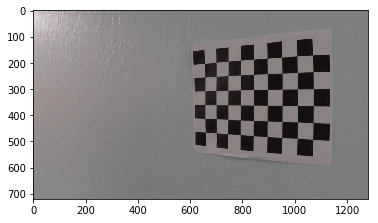

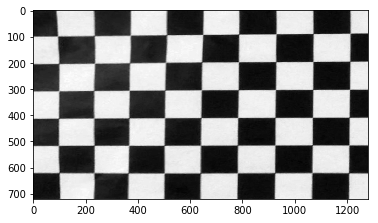

In [8]:
plt.imshow(test_image_read)
plt.show()
plt.imshow(test_top_down, cmap="gray")
plt.show()


# Combination between Gradient and Color thresholging methods

In [9]:


# In this part, we will test using (test images) folder for the road in order to
# have a good way of comparison with the output generated in the lectures

#Gradient thresold functions

# Absolute sobel threshold
def abs_sobel_thresh(img, orient, sobel_kernel, thresh):
    # Notes: 
    # 1) sobel_kernel must be odd
    # 2) thresh is a tuble (thresh_min = , thresh_max = )
    
    # This image must be read by cv2
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == "x":
        # calculate sobelx
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == "y":
        # calculate sobely
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # take the absolute value of the derivative
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0-255) then cast to be np.uint8
    Scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude 
    # is greater than threshold min and less than the threshold max
    binary_output = np.zeros_like(Scaled_sobel)
    binary_output[(Scaled_sobel >= thresh[0]) & (Scaled_sobel < thresh[1])] = 1
    
    return binary_output





# Magnitude threshold
def mag_thresh(img, sobel_kernel, mag_thresh):
    # It will be implemented as the previous, but calculating sobel from the magnitude of both x and y
    # Notes: 
    # 1) sobel_kernel must be odd
    # 2) mag_thresh is a tuble (mag_thresh_min = , mag_thresh_max = )
    
    # This image must be read by cv2
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate sobel x and y then calculate their magnitude
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag_sobel = np.sqrt(sobelx**2 + sobely**2)
    # Scale to 8-bit (0-255) and cast to be uint8 
    Scaled_sobel = (255*mag_sobel/np.max(mag_sobel)).astype('uint8')
    # Create the mask using the boundary thresolds
    binary_output = np.zeros_like(Scaled_sobel)
    binary_output[(Scaled_sobel >= mag_thresh[0]) & (Scaled_sobel < mag_thresh[1])] = 1
    
    return binary_output







# Direction of the gradient threshold
def dir_thresh(img, sobel_kernel, dir_thresh):
    # It will be implemented as the previous, but calculating sobel angle (gradient) using arctan2 
    # Notes:
    # 1) sobel_kernel must be odd
    # 2) dir_thresh is a tuble (dir_thresh_min = , dir_thresh_max = )
    
    # This image must be read by cv2
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate sobel x and y then calculate their magnitude
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # calculate the absolute value of both of sobelx, and sobely
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # calculate the gradient using the arctan2 to put threshold
    dir_grad = np.arctan2(abs_sobely,abs_sobelx)
    # Create the mask using the boundary thresolds
    binary_output = np.zeros_like(dir_grad)
    binary_output[(dir_grad >= dir_thresh[0]) & (dir_grad < dir_thresh[1])] = 1
    
    return binary_output



In [10]:
# Color thresold functions

def hls_select(img, hls_thresh):
    # Notes:
    # 1) hls_thresh is a tuble (hls_thresh_min = , hls_thresh_max = )
    
    # This image must be read by cv2
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # apply thresholding to have the S-channel only from the HLS components
    S_Channel = hls[:,:,2] 
    # Create the mask using the boundaries
    binary_output = np.zeros_like(S_Channel)
    binary_output[(S_Channel >= hls_thresh[0]) & (S_Channel <= hls_thresh[1])] = 1
    
    return binary_output


# Binary thresold in order to make the shadow unseen
def LAB_select(img, LAB_thresh):
    LAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    B_Channel = LAB[:,:,2]
    # Create the mask using the boundaries
    binary_output = np.zeros_like(B_Channel)
    binary_output[(B_Channel >= LAB_thresh[0]) & (B_Channel <= LAB_thresh[1])] = 1
    
    return binary_output


# hsv thresholding in order to put threshold for yellow and white colors
def hsv_select(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    yellow_mask = cv2.inRange(hsv, np.array((0,100,100)), np.array((80,255,255)))
    white_mask = cv2.inRange(img, np.array((200,200,200)), np.array((255,255,255)))
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    binary_output = np.zeros_like(mask)
    binary_output[(mask == 255)] = 1

    return binary_output




# Define the Pipeline of thresolding based on both Gradient and color thresholding

In [11]:
def Pipline_threshold(image):
    Absolute_thresholding_x         = abs_sobel_thresh(image, orient = "x", sobel_kernel = 9, thresh = (40,100) )
    Absolute_thresholding_y         = abs_sobel_thresh(image, orient = "y", sobel_kernel = 9, thresh = (80,180) )
    Magnitude_thresholding          = mag_thresh(image, sobel_kernel = 9, mag_thresh = (50,150) )
    Gradient_Direction_thresholding = dir_thresh(image, sobel_kernel = 9, dir_thresh = (0,np.pi/2) )
    HLS_thresholding                = hls_select(image, hls_thresh = (255,255))
    LAB_thresholding                = LAB_select(image, LAB_thresh=(40,100))
    HSV_thresholding                = hsv_select(image)
    
    Combined_binary = np.zeros_like(Absolute_thresholding_x)
    '''
    (Absolute_thresholding_x == 1) |
    (LAB_thresholding == 1) |
    ((HLS_thresholding == 1) & (Gradient_Direction_thresholding == 1))
    '''
    Combined_binary[(HSV_thresholding == 1) |
                   (Absolute_thresholding_x == 1)
                   ] = 1
    
    color_binary = np.dstack((np.zeros_like(Absolute_thresholding_x), Absolute_thresholding_x, HLS_thresholding)) * 255
    
    return Combined_binary, color_binary

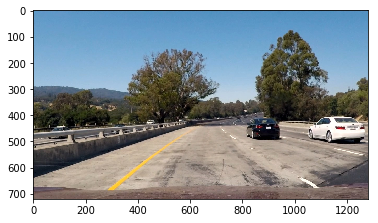

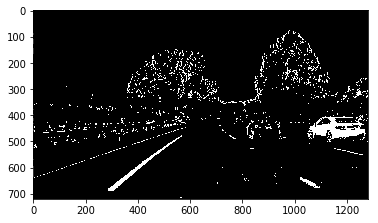

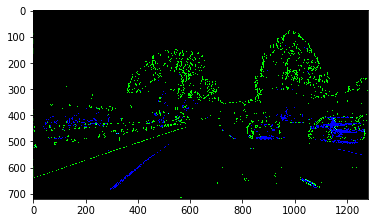

In [12]:
# Testing for the previous thresholding 
test_image_pipeline = "test_images/test1.jpg"
Read_test_image_pipeline = mpimg.imread(test_image_pipeline)

output_combined_binaries, coloring_binary = Pipline_threshold(Read_test_image_pipeline)

plt.imshow(Read_test_image_pipeline)
plt.show()
plt.imshow(output_combined_binaries, cmap="gray")
plt.show()
plt.imshow(coloring_binary, cmap="gray")
plt.show()


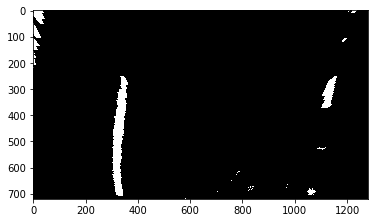

In [13]:
## Prespective Transform Check on these images in order to have Bird's view for the street
Source_road_points = np.float32([[575,460], [150,720], [1150,720], [700,460]])
Destination_road_points = np.float32([[250,0], [250,720], [1050,720], [1050,0]])

Source_road_points = np.float32([[575,460], [150,720], [1150,720], [700,460]])
Destination_road_points = np.float32([[250,0], [250,720], [1050,720], [1050,0]])


test_top_down_road, test_road_prespective_M = corners_unwrap(test_image_pipeline, 
                                                             n_rows, n_cols, dict_pickle["mtx"],dict_pickle["dist"], 
                                                             Source_road_points, Destination_road_points, True)

#plt.imshow(test_top_down_road, cmap="gray")
#plt.show()

test_top_down_road, test_road_prespective_M = corners_unwrap(output_combined_binaries, 
                                                             n_rows, n_cols, dict_pickle["mtx"],dict_pickle["dist"], 
                                                             Source_road_points, Destination_road_points, False)

plt.imshow(test_top_down_road, cmap="gray")
plt.show()


In [ ]:
'''
Now we have done the following steps:
    1- Camera Calibration
    2- Image Distortion Correction
    3- Gradient and Color thresholding
    4- Prespective transform to have a Bird's eye images
    
Now we want to do the following steps:
    1- Locate the Lanes lines using the code in the lectures (Using the Histogram method of the two peaks)
    2- Using the sliding window in order to know the full Lane Lines in the image
    3- Fitting a polynomial for the Lane using the codes in the lectures
    4- Measuring the Curvature (Remember: within approx. 1k.m)
    
For the Full Pipeline:
    1- Work on the video to extract the images frame by frame (Not Yet)
    2- Image Distortion and Correction (Done)
    3- Gradient and Color thresholding (DOne)
    4- Prespective transform to have the Bird's eye images that facilitate 
    extracting the Lanes Lines and fit a polynomial (Done)
    5- Extract Lanes Lines using the Histogram method (Not Yet)
    6- Apply Sliding window to locate the whole lines (Not Yet)
    7- Fitting a polynomial for the whole lane lines (Not Yet)
    8- Measure the Lanes Curvature (Not Yet)
    9- Save the video (Not Yet)
'''

In [14]:
# Plot the histogram of the output image

def Calculate_histogram(image, plotting=False):
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    if plotting == True:
        plt.plot(histogram,"b")
        plt.show()
    
    return histogram

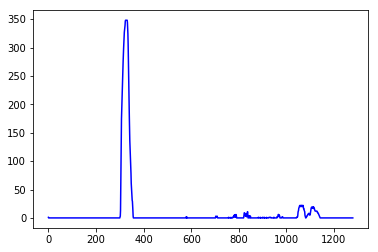

array([1, 0, 0, ..., 0, 0, 0], dtype=uint32)

In [15]:
# test the Histogram function
Calculate_histogram(test_top_down_road, plotting=True)

# Thios means that the two lanes lines are located at the two peaks

# Finding the Lanes Lines and Fit a polynomial

In [16]:
def PolynomialFit_LanesLines(image):
    # The input image should be the Bird's eye image
    
    # Choose the number of sliding windows
    nwindows = 13
    # Set the width of the windows +/- margin
    margin = 70
    # Set minimum number of pixels found to recenter window
    minpix = 50
        
    # Take a histogram of the bottom half of the image
    histogram = Calculate_histogram(image, plotting=False)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((image, image, image))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
                      (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
                      (win_xright_high,win_y_high),(0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    print(leftx)
    print(lefty)
    print(rightx)
    print(righty)
    
    global Current_fit_Left
    global Current_fit_Right
    
    print(Current_fit_Left, Current_fit_Right)
    
    
    # Sanity Check if the lanes are detected or not
    if (len(leftx) == 0):
        print("Lanes are not detected")
        # Call the function that draws lines without using sliding window
        left_fit, right_fit, out_img, leftx, lefty, rightx, righty = Skip_SlidingWindow_Visualization(out_img, Current_fit_Left, Current_fit_Right)
        
    else:
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
    Current_fit_Left = left_fit
    Current_fit_Right = right_fit
    
    print(Current_fit_Left, Current_fit_Right)
    
    return left_fit, right_fit, out_img, leftx, lefty, rightx, righty

In [19]:
def PolynomialFit_Visulaization(image):
    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    
    left_fit, right_fit, output_image, L_x, L_y, R_x, R_y = PolynomialFit_LanesLines(image)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    #output_image[L_y, L_x] = [255, 0, 0]
    #output_image[R_y, R_x] = [0, 0, 255]
    
    plt.imshow(output_image)
    #global i
    #plt.imsave("output_images/warped_imgs/" + str(i) + ".jpg", output_image)
    #i += 1
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.show()
    
    return left_fitx, right_fitx, left_fit, right_fit, L_x, L_y, R_x, R_y

[312 313 314 ..., 360 361 362]
[665 665 665 ..., 279 279 279]
[1071 1072 1056 ..., 1225 1226 1227]
[666 666 680 ...,  11  11  11]
[  2.95385271e-04  -3.41749069e-01   4.20456330e+02] [  1.70505250e-04  -3.45889105e-01   1.22295366e+03]
[  2.95385271e-04  -3.41749069e-01   4.20456330e+02] [  1.70505250e-04  -3.45889105e-01   1.22295366e+03]


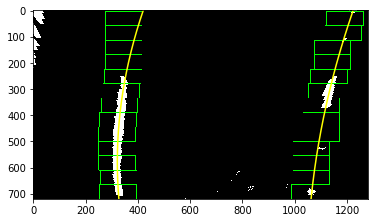

In [20]:
LeftFitX, RightFitX, LeftFit, RightFit, Left_X, Left_Y, Right_X, Right_Y = PolynomialFit_Visulaization(test_top_down_road)


# Skipping Function for the sliding window technique.

In [21]:
 
# This Function could be used when we know the positions of the Lanes Lines

def Skip_SlidingWindow(image, left_fit, right_fit):
    # Set the width of the windows +/- margin
    margin = 70
    
    # Create an image to draw on 
    #output_image = np.dstack((image, image, image))*255
    
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    print("Here: ", left_fit)
    print("Here: ", right_fit)
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit_poly = np.polyfit(lefty, leftx, 2)
    right_fit_poly = np.polyfit(righty, rightx, 2)
    
    return left_fit_poly, right_fit_poly, image, leftx, lefty, rightx, righty

In [22]:
# Visualize fitting without Sliding window

def Skip_SlidingWindow_Visualization(image, left_fit, right_fit):
    # Set the width of the windows +/- margin
    margin = 70
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    LFit, RFit, output_image, Lx, Ly, Rx, Ry = Skip_SlidingWindow(image, left_fit, right_fit) 
    
    left_fitx = LFit[0]*ploty**2 + LFit[1]*ploty + LFit[2]
    right_fitx = RFit[0]*ploty**2 + RFit[1]*ploty + RFit[2]
    
    # Create an image to show the selection window
    #window_img = np.zeros_like(output_image)
    
    # Color in left and right line pixels
    #output_image[Ly, Lx] = [255, 0, 0]
    #output_image[Ry, Rx] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    #left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    #left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    #left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    #right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    #right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    #right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    #cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    #cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    #result = cv2.addWeighted(output_image, 1, window_img, 0.3, 0)
    #plt.imshow(result)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.show()
    
    return LFit, RFit, output_image, Lx, Ly, Rx, Ry
    

In [23]:
# Visualization for Skipping Window technique
Skip_SlidingWindow_Visualization(test_top_down_road, LeftFit, RightFit)

# Here I have used the same output of the same image in order to check the functionality of Skipping Sliding window 

Here:  [  2.95385271e-04  -3.41749069e-01   4.20456330e+02]
Here:  [  1.70505250e-04  -3.45889105e-01   1.22295366e+03]


(array([  2.95385271e-04,  -3.41749069e-01,   4.20456330e+02]),
 array([  1.72437224e-04,  -3.47768951e-01,   1.22334982e+03]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([334, 335, 336, ..., 341, 342, 343], dtype=int64),
 array([253, 253, 253, ..., 707, 707, 707], dtype=int64),
 array([1207, 1208, 1209, ..., 1043, 1044, 1045], dtype=int64),
 array([  0,   0,   0, ..., 703, 703, 703], dtype=int64))

# Measuring the Curvature Function in pixels

In [24]:
def Curvature_Measurement_pix(image, left_fit, right_fit, leftx, lefty, rightx, righty):
    left_curverad = ((1 + (2*left_fit[0]*np.max(lefty) + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*np.max(righty) + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, "in pixels", right_curverad, "in pixels")
    
    
# Test the Radius of Curvature
Curvature_Measurement_pix(test_top_down_road, LeftFit, RightFit, Left_X, Left_Y, Right_X, Right_Y)

# Measuring the Curvature Function in meters

In [25]:
def Curvature_Measurement_m(image, left_fit, right_fit, leftx, lefty, rightx, righty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad  = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(righty) + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    
    return left_curverad, right_curverad
    
# Test the Radius of Curvature
Curvature_Measurement_m(test_top_down_road, LeftFit, RightFit, Left_X, Left_Y, Right_X, Right_Y)

(2209.151315252861, 1717.6900268976001)

# Reverse Projection for the image and fill between the two polylines for the lanes

In [26]:
def Reverse_and_Fill(original_image, warped_image, left_fitx, right_fitx, Minv):
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0])

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original_image.shape[1], original_image.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    #plt.show()
    
    return result
    
Reverse_and_Fill(Read_test_image_pipeline, test_top_down_road, LeftFitX, RightFitX, np.linalg.inv(test_road_prespective_M))

array([[[254, 233, 216],
        [245, 238, 232],
        [196, 205, 212],
        ..., 
        [ 16,  35,  52],
        [ 20,  37,  53],
        [ 32,  48,  63]],

       [[245, 238, 232],
        [188, 193, 197],
        [137, 158, 175],
        ..., 
        [ 74, 108, 135],
        [ 47,  77, 103],
        [  4,  34,  60]],

       [[193, 202, 209],
        [134, 157, 173],
        [115, 154, 183],
        ..., 
        [ 95, 144, 184],
        [ 89, 137, 177],
        [ 52,  97, 136]],

       ..., 
       [[141, 131, 129],
        [132, 121, 119],
        [114, 100,  97],
        ..., 
        [ 99,  80,  74],
        [ 99,  80,  74],
        [113,  94,  88]],

       [[164, 154, 152],
        [133, 122, 120],
        [120, 106, 103],
        ..., 
        [107,  88,  82],
        [109,  90,  84],
        [111,  92,  86]],

       [[189, 179, 177],
        [135, 125, 123],
        [128, 117, 113],
        ..., 
        [ 97,  78,  72],
        [ 95,  76,  70],
        [ 73,  54,

# Write on Every Image in the video during creation

In [27]:
# This Function writes on the image some measurements

def Write_Measurements(image, Radius_curve, leftfitx, rightfitx):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    Veh_position = image.shape[1]//2
    middle = (leftfitx[-1] + rightfitx[-1])//2
    dx = (Veh_position - middle) * xm_per_pix # Positive if on right, Negative on left
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image,'Left radius of curvature  = %.2f m'%(Radius_curve[0]),(50,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(image,'Right radius of curvature = %.2f m'%(Radius_curve[1]),(50,80), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(image,'Vehicle position : %.2f m %s of center'%(abs(dx), 'left' if dx < 0 else 'right'),(50,110), font, 1,(255,255,255),2,cv2.LINE_AA)

    return image

# Full Pipeline

In [28]:
'''
Now we want to apply all of the previous steps over the images extracted from the project video frame by frame.
But first we need to construct the Full Pipeline in One function in order facilitate tracing the code

We will follow the following steps:
    1- We have calibrated the camera, so we will use its parameters (Done)
    2- Image Distortion correction (Done)
    3- Apply Gradient and Color thresholding (Done)
    4- Apply prespective transform till have the Bird's eye view (Done)
    5- Polynomial Fitting (Done)
    6- Calculate both (Radius of Curvature and the Car's Position away from the 2 lane lines) (Not Yet Totally)
    7- Reverse and Fill between the two Line Lanes (Done)
    8- Write Left and Right Radius on the image in addition to the Car's position
    
Important Note: The image is already read, so every read using mpimg or cv2 will be commented
'''

for_testing = [0,1,2,3,4,5,6,7]
i = 0

def Advanced_Lane_Finding(image):
    # Read from the Chessboard images we have
    n_rows = 9 # rows corners in the chessboard
    n_cols = 6 # columns corners in the chessboard
    
    Src_road_pts = np.float32([[575,460], [150,720], [1150,720], [700,460]])
    Dest_road_pts = np.float32([[250,0], [250,720], [1050,720], [1050,0]])
    
    plt.imshow(image)
    plt.show()
    
    
    #Destination_road_points = np.float32([[250,0], [250,720], [1050,720], [1050,0]])
    
    # 1- Load the saved pickle that contains the Camera Calibration parameters
    Cal_Params = pickle.load(open("camera_calibrate.p", 'rb'))
    
    ##################################################################################################
    
    # 2- Use the Calibration parameters to undistort the input image
    undist_image = cv2.undistort(image, Cal_Params["mtx"], Cal_Params["dist"], None, Cal_Params["mtx"])
    
    #plt.imshow(undist_image)
    #plt.show()
    
    ##################################################################################################
    
    # 3- Apply Gradient and Color thresholding
    image_binaries, image_color_binary = Pipline_threshold(undist_image)
    
    #plt.imshow(image_binaries, cmap="gray")
    #plt.show()
    
    ##################################################################################################
    
    # 4- Apply prespective transform
    image_warped, image_M = corners_unwrap(image_binaries, n_rows, n_cols, 
                                                  Cal_Params["mtx"],Cal_Params["dist"], 
                                                  Src_road_pts, Dest_road_pts, False)
    #plt.imshow(image_warped, cmap="gray")
    #plt.show()
    
    ##################################################################################################
    
    # 5- Polynomial Fitting and draw rectangles in green with the pplynomial lines in yellow with Visualization
    LFitX, RFitX, LFit, RFit, LX, LY, RX, RY = PolynomialFit_Visulaization(image_warped)
    
    ##################################################################################################
    
    # 6- Calculate Radius Curvature
    R_curve_pix = Curvature_Measurement_pix(image_warped, LFit, RFit, LX, LY, RX, RY)
    R_curve_met = Curvature_Measurement_m(image_warped, LFit, RFit, LX, LY, RX, RY)
    
    ##################################################################################################
    
    # 7- Reverse and Fill between the two lines
    image_output = Reverse_and_Fill(image, image_warped, LFitX, RFitX, np.linalg.inv(image_M))
    
    ##################################################################################################
    
    # 8- Write Measurements on the video's image
    image_output_with_measurements = Write_Measurements(image_output, R_curve_met, LFitX, RFitX)
    #plt.imshow(image_output_with_measurements)
    #plt.show()

    return image_output_with_measurements

['test_images\\straight_lines1.jpg', 'test_images\\straight_lines2.jpg', 'test_images\\test1.jpg', 'test_images\\test2.jpg', 'test_images\\test3.jpg', 'test_images\\test4.jpg', 'test_images\\test5.jpg', 'test_images\\test6.jpg']
straight_lines1.jpg


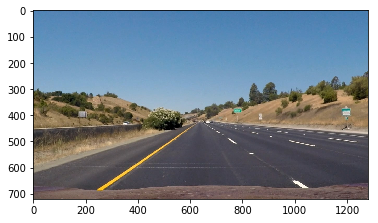

[283 284 285 ..., 338 339 340]
[665 665 665 ...,  59  59  59]
[1022 1026 1019 ..., 1092 1093 1094]
[688 688 689 ...,  59  59  59]
[  2.95385271e-04  -3.41749069e-01   4.20456330e+02] [  1.70505250e-04  -3.45889105e-01   1.22295366e+03]
[ -2.54551891e-05   2.34172731e-02   2.93890097e+02] [  6.61857582e-05  -1.06563175e-01   1.06039849e+03]


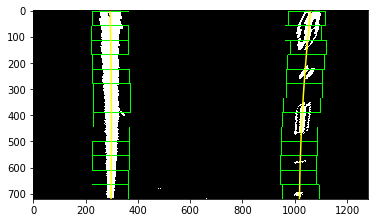

###########################################################
straight_lines2.jpg


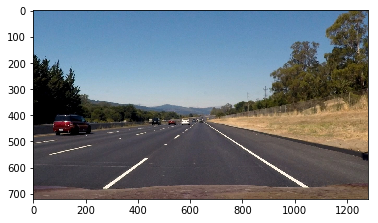

[289 290 294 ..., 329 330 331]
[665 665 665 ...,  11  11  11]
[1003 1004 1005 ..., 1116 1117 1118]
[665 665 665 ...,  59  59  59]
[ -2.54551891e-05   2.34172731e-02   2.93890097e+02] [  6.61857582e-05  -1.06563175e-01   1.06039849e+03]
[  4.60294187e-05  -1.07933406e-02   2.89491504e+02] [ -3.15152577e-06  -9.26526224e-02   1.08221066e+03]


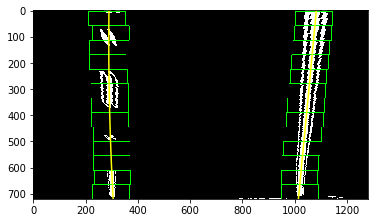

###########################################################
test1.jpg


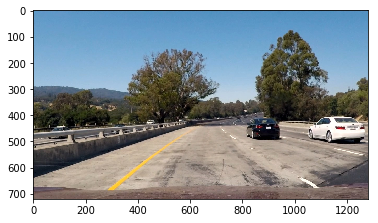

[312 313 314 ..., 360 361 362]
[665 665 665 ..., 279 279 279]
[ 983 1053 1054 ..., 1203 1204 1203]
[673 686 686 ...,   9   9  10]
[  4.60294187e-05  -1.07933406e-02   2.89491504e+02] [ -3.15152577e-06  -9.26526224e-02   1.08221066e+03]
[  3.17666033e-04  -3.65807061e-01   4.27236309e+02] [  5.83644584e-05  -2.41582582e-01   1.19991221e+03]


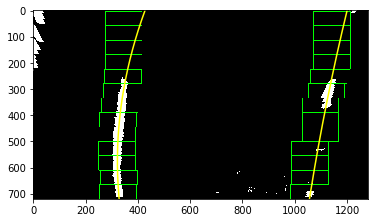

###########################################################
test2.jpg


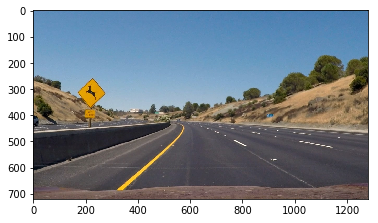

[346 347 348 ..., 273 274 275]
[665 665 665 ...,  59  59  59]
[1044 1045 1041 ..., 1062 1063 1064]
[666 666 667 ...,  59  59  59]
[  3.17666033e-04  -3.65807061e-01   4.27236309e+02] [  5.83644584e-05  -2.41582582e-01   1.19991221e+03]
[ -2.87056928e-04   3.98475861e-01   2.23138973e+02] [  2.30410749e-05   1.35823687e-01   1.00951805e+03]


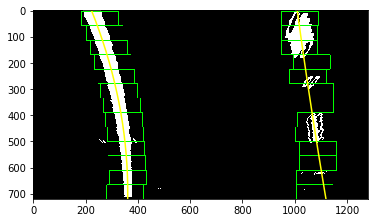

###########################################################
test3.jpg


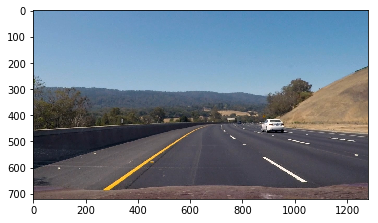

[306 307 308 ..., 505 506 507]
[665 665 665 ...,  59  59  59]
[1033 1034 1035 ..., 1235 1236 1237]
[665 665 665 ...,  59  59  59]
[ -2.87056928e-04   3.98475861e-01   2.23138973e+02] [  2.30410749e-05   1.35823687e-01   1.00951805e+03]
[  1.55723764e-04  -3.52077057e-01   4.89230879e+02] [  1.54675542e-04  -3.84860334e-01   1.23856754e+03]


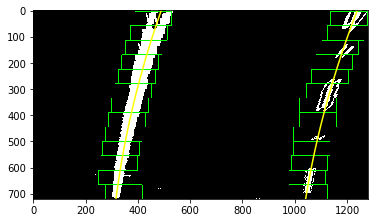

###########################################################
test4.jpg


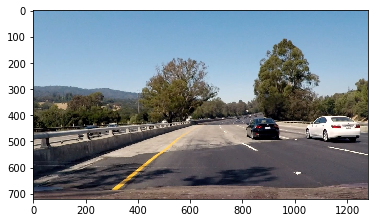

[327 328 329 ..., 370 371 372]
[665 665 665 ..., 224 224 224]
[1105 1106 1107 ..., 1228 1229 1230]
[672 672 672 ...,  59  59  59]
[  1.55723764e-04  -3.52077057e-01   4.89230879e+02] [  1.54675542e-04  -3.84860334e-01   1.23856754e+03]
[  2.01204778e-05  -5.07247535e-02   3.67857440e+02] [  1.99904628e-04  -3.60192257e-01   1.23399043e+03]


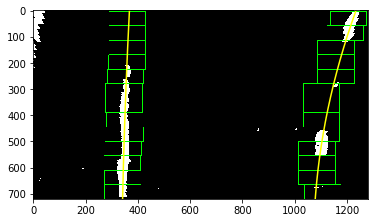

###########################################################
test5.jpg


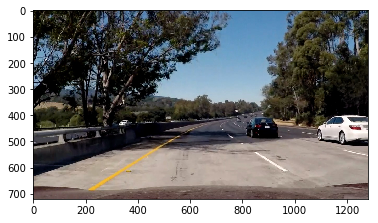

[249 250 251 ..., 386 387 388]
[665 665 665 ...,  52  52  52]
[1036 1037 1038 ..., 1166 1167 1168]
[665 665 665 ..., 224 224 224]
[  2.01204778e-05  -5.07247535e-02   3.67857440e+02] [  1.99904628e-04  -3.60192257e-01   1.23399043e+03]
[  2.64187507e-04  -3.58599017e-01   3.86441493e+02] [  2.20143936e-04  -4.12203149e-01   1.22652124e+03]


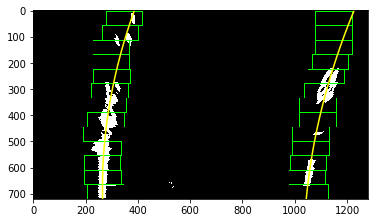

###########################################################
test6.jpg


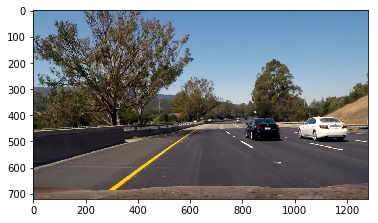

[324 325 326 ..., 516 517 518]
[665 665 665 ...,  59  59  59]
[1109 1110 1111 ..., 1277 1278 1279]
[632 632 632 ...,  59  59  59]
[  2.64187507e-04  -3.58599017e-01   3.86441493e+02] [  2.20143936e-04  -4.12203149e-01   1.22652124e+03]
[  1.34617900e-04  -3.51537687e-01   5.14891522e+02] [  2.34961082e-04  -4.38893604e-01   1.27894983e+03]


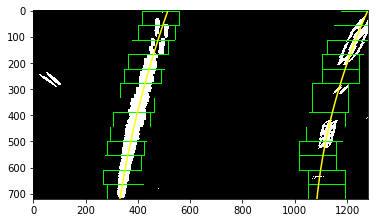

###########################################################


In [29]:
Test_images_Folder = "test_images/*.jpg"
All_File = glb.glob(Test_images_Folder)

print(All_File)

for im in All_File:
    print(im[12:])
    Im_Read = mpimg.imread(im)
    Advanced_Lane_Finding(Im_Read)
    print("###########################################################")


In [30]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()


In [ ]:
project_output_video = "project_output_video.mp4"
clip = VideoFileClip("project_video.mp4")
output_video = clip.fl_image(Advanced_Lane_Finding) #  .subclip(0,35)   NOTE: this function expects color images!!
%time output_video.write_videofile(project_output_video, audio=False)

In [ ]:
# project_output_video = "challenge_output_video.mp4"
# clip = VideoFileClip("challenge_video.mp4")
# output_video = clip.fl_image(Advanced_Lane_Finding)# NOTE: this function expects color images!!
# %time output_video.write_videofile(project_output_video, audio=False)

In [ ]:
# project_output_video = "harder_challenge_output_video.mp4"
# clip = VideoFileClip("harder_challenge_video.mp4")
# output_video = clip.fl_image(Advanced_Lane_Finding) #NOTE: this function expects color images!!
# %time output_video.write_videofile(project_output_video, audio=False)